In [1]:
# help from https://witestlab.poly.edu/blog/capture-and-decode-fm-radio/

import numpy as np
from rtlsdr import RtlSdr
from scipy import signal
import matplotlib.pyplot as plt
import wave

In [2]:
sdr = RtlSdr()

duration = 10
F_station = int(95.9e6)
F_offset = 250000

Fc = F_station - F_offset
Rs = int(2.8e6)
N = int(duration * Rs)

# configure device
sdr.set_sample_rate(Rs)
sdr.set_center_freq(Fc)
sdr.set_freq_correction(66)
sdr.set_gain('auto')

In [3]:
samples = sdr.read_samples(N)

# Clean up the SDR device
sdr.close()
del(sdr)

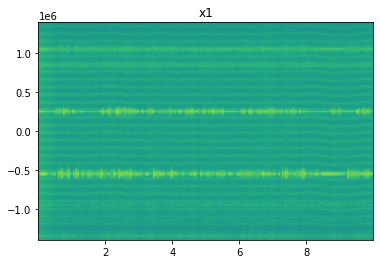

In [4]:
x1 = np.array(samples).astype("complex64")

plt.specgram(x1, NFFT=2048, Fs=Rs)
plt.title("x1")
plt.ylim(-Rs/2, Rs/2)
plt.show()

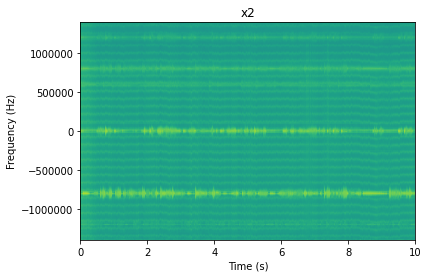

In [5]:
fc1 = np.exp(-1.0j*2.0*np.pi * F_offset/Rs*np.arange(len(x1)))
x2 = x1 * fc1

plt.specgram(x2, NFFT=2048, Fs=Rs)
plt.title("x2")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(-Rs/2, Rs/2)
plt.xlim(0, len(x2)/Rs)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [6]:
# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 200000
n_taps = 64
# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(Rs/2-f_bw)/4, Rs/2], [1, 0], Hz=Rs)
x3 = signal.lfilter(lpf, 1.0, x2)

dec_rate = int(Rs / f_bw)
x4 = x3[0::dec_rate]
# Calculate the new sampling rate
Fs_y = Rs/dec_rate

# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 200000
dec_rate = int(Rs / f_bw)
x4 = signal.decimate(x2, dec_rate)
# Calculate the new sampling rate
Fs_y = Rs/dec_rate

[]

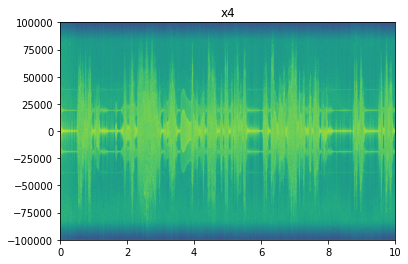

In [7]:
plt.specgram(x4, NFFT=2048, Fs=Fs_y)
plt.title("x4")
plt.ylim(-Fs_y/2, Fs_y/2)
plt.xlim(0, len(x4)/Fs_y)
plt.ticklabel_format(style='plain', axis='y')
plt.plot()

[]

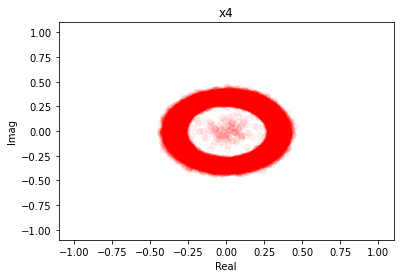

In [8]:
plt.scatter(np.real(x4[0:50000]), np.imag(x4[0:50000]), color="red", alpha=0.05)
plt.title("x4")
plt.xlabel("Real")
plt.xlim(-1.1, 1.1)
plt.ylabel("Imag")
plt.ylim(-1.1, 1.1)
plt.plot()

In [9]:
y5 = x4[1:] * np.conj(x4[:-1])
x5 = np.angle(y5)

[]

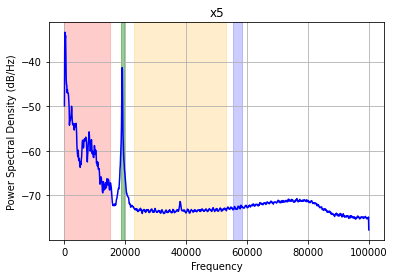

In [10]:
plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")
plt.title("x5")
plt.axvspan(0,             15000,         color="red", alpha=0.2)
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)
plt.ticklabel_format(style='plain', axis='y')
plt.plot()

In [11]:
# The de-emphasis filter
# Given a signal 'x5' (in a numpy array) with sampling rate Fs_y
d = Fs_y * 75e-6   # Calculate the # of samples to hit the -3dB point
x = np.exp(-1/d)   # Calculate the decay between each sample
b = [1-x]          # Create the filter coefficients
a = [1, -x]
x6 = signal.lfilter(b, a, x5)

In [12]:
# Find a decimation rate to achieve audio sampling rate between 44-48 kHz
audio_freq = 44100.0
dec_audio = int(Fs_y/audio_freq)
Fs_audio = Fs_y / dec_audio

x7 = signal.decimate(x6, dec_audio)

# Scale audio to adjust volume
x7 *= 10000 / np.max(np.abs(x7))
# Save to file as 16-bit signed single-channel audio samples
x7.astype("int16").tofile("wbfm-mono.raw")

In [13]:
with open("wbfm-mono.raw", 'rb') as opened_pcm_file:
    pcm_data = opened_pcm_file.read();
wav_obj = wave.open('wbfm.wav', 'wb')
wav_obj.setnchannels(1)
wav_obj.setsampwidth(2)
wav_obj.setframerate(44100)
wav_obj.writeframes(pcm_data)
wav_obj.close()